In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from os import listdir
from os.path import isfile, join

from packages.funcs import Statistics

plt.style.use("packages/mystyle.mplstyle")

In [29]:
datasets_names = [
    f[:-4]
    for f in listdir("data")
    if f
    not in [
        ".DS_Store",
        "Misure accel grav giorno2.xlsx",
        "~$Misure accel grav giorno2.xlsx",
        "misure fototraguardo, angoli diversi, 3-5-7-10-15 gradi.csv",
        "Pendolo.xlsx",
    ]
]
datasets_names.sort()

print(datasets_names)

['misura fototraguardo lunghezza 1(min)', 'misura fototraguardo lunghezza 2_mat', 'misura fototraguardo lunghezza 2_tia', 'misura fototraguardo lunghezza 3_fil', 'misura fototraguardo lunghezza 3_mat', 'misura fototraguardo lunghezza 3_tia', 'misura fototraguardo lunghezza 4_fil', 'misura fototraguardo lunghezza 4_mat', 'misura fototraguardo lunghezza 4_tia', 'misura fototraguardo lunghezza 5_fil', 'misura fototraguardo lunghezza 5_mat', 'misura fototraguardo lunghezza 5_tia']


In [30]:
datasets = {}
massa_gancio = 19.88
massa_masse = 79.56
massa_tot = 19.88 + 79.56
lunghezze = (
    np.array(
        [
            206.10,
            172.58,
            172.58,
            127.46,
            127.06,
            128.24,
            99.06,
            99.08,
            99.22,
            67.56,
            67.86,
            67.90,
        ]
    )
    / 1000
)

for dataset_name in datasets_names:
    with open(f"data/{dataset_name}.csv", "r") as file:
        datasets[dataset_name] = pd.read_csv(file, sep=";", decimal=",").dropna()

In [31]:
# Calculate center of mass

altezza_base_gancio = 71.38 / 1000
altezza_masse = 21.28 / 1000

cm = (altezza_base_gancio * massa_gancio + altezza_masse * massa_masse) / massa_tot

lunghezze = lunghezze - cm

In [32]:
periods = []
std_periods = []

for dataset_name, dataset in datasets.items():
    X = dataset.iloc[:, 0].to_numpy()
    Y = dataset.iloc[:, 1].to_numpy()

    mean_period = Y.mean()
    std_period = Y.std()

    print(f"{mean_period:.4f} ± {std_period:.4f}")
    periods.append(mean_period)
    std_periods.append(std_period)

periods = np.array(periods)
std_periods = np.array(std_periods)

1.2387 ± 0.0004
1.2927 ± 0.0003
1.2931 ± 0.0002
1.3631 ± 0.0003
1.3622 ± 0.0002
1.3620 ± 0.0002
1.4018 ± 0.0002
1.4023 ± 0.0002
1.4033 ± 0.0002
1.4471 ± 0.0002
1.4474 ± 0.0001
1.4473 ± 0.0002


[0.00041425 0.00028951 0.00022048 0.00026372 0.00016564 0.00017468
 0.00020467 0.00024123 0.00016586 0.00022209 0.0001331  0.00015206]
[0.00102626 0.00074849 0.00057023 0.00071897 0.00045129 0.00047583
 0.00057379 0.00067657 0.00046551 0.00064278 0.00038529 0.00044013]
[0.00104557 0.00077475 0.00060428 0.00074627 0.00049362 0.00051616
 0.00060765 0.00070551 0.00050665 0.00067318 0.00043411 0.00048344]
parameters: -4.0293±0.0044 2.2419±0.0004
g=9.7979 ±0.0108


Text(0, 0.5, 'Periodi al quadrato $T^2$ [$\\text{s}^2$]')

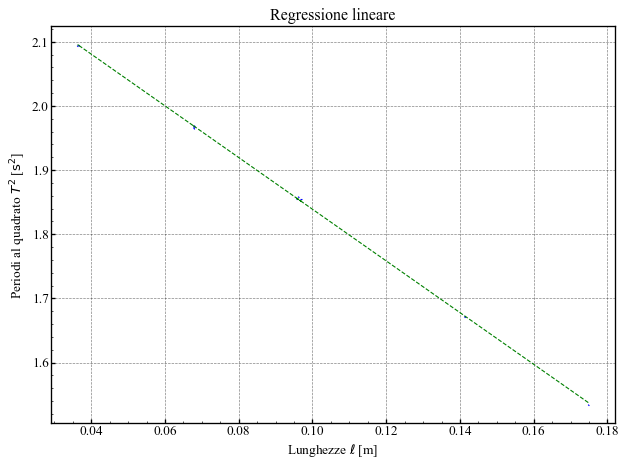

In [33]:
squared_periods = np.square(periods) * (
    1 + (0.005 / (2 * np.pi)) ** 2  # correzione smorzamento
)
squared_p_std = 2 * np.multiply(std_periods, periods)
xerr = 0.2 / 1000
err = np.sqrt(np.square(squared_p_std) + np.square(xerr))
print(std_periods)
print(squared_p_std)
print(err)

plt.errorbar(lunghezze, squared_periods, fmt="bx ", yerr=squared_p_std, xerr=xerr)

retta = lambda x, a, b: a * x + b

params, cov = scipy.optimize.curve_fit(
    retta, lunghezze, squared_periods, sigma=err, absolute_sigma=True
)
std = np.sqrt(np.diag(cov))

print("parameters:", *[f"{param:.4f}±{err:.4f}" for param, err in zip(params, std)])
g = -(4 * np.pi**2) / params[0]
g_std = -std[0] / params[0] * g
print(f"{g=:.4f} ±{g_std:.4f}")

plt.plot(
    lunghezze,
    retta(lunghezze, *params),
    ls="--",
    c="g",
)

plt.title("Regressione lineare")
plt.xlabel(r"Lunghezze $\ell$ [m]")
plt.ylabel(r"Periodi al quadrato $T^2$ [$\text{s}^2$]")

[9.69378377e-02 5.08494926e-05 1.40080460e+00] [2.11374897e+00 1.11770254e-03 2.11379428e+00]
[8.40585417e-04 4.53428361e-03 1.49799331e+00] [0.00020439 0.00211546 0.00022791]
[0.00272833 0.00328015 1.49746495] [0.0004596  0.00087977 0.00048822]
[0.00489329 0.00412843 1.49787799] [0.00011511 0.00018244 0.00012766]
[0.00985116 0.00502419 1.49903239] [7.64621300e-05 7.98780959e-05 8.68871363e-05]


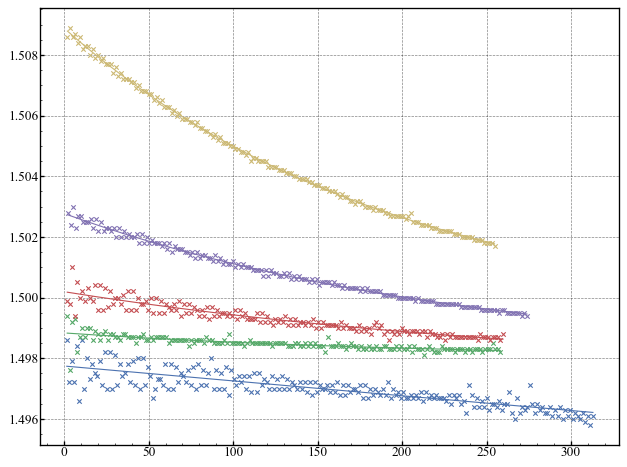

In [34]:
exp_func = lambda x, a, b, c: a * np.exp(-b * x) + c

with open(
    "data/misure fototraguardo, angoli diversi, 3-5-7-10-15 gradi.csv", "r"
) as file:
    data = pd.read_csv(file, delimiter=";", decimal=",").iloc[0:]

for i in range(0, 10, 2):
    X = data.iloc[:, i].dropna().to_numpy()
    Y = data.iloc[:, i + 1].dropna().to_numpy()
    plt.scatter(X, Y, marker="x")

    params, cov = scipy.optimize.curve_fit(
        exp_func,
        X,
        Y,
        p0=[0.001, 0.001, 1.5],
        maxfev=3000,
        bounds=((0, 0, 1.4), (10, 1, 1.6)),
    )
    std = np.sqrt(np.diag(cov))

    print(params, std)
    plt.plot(X, exp_func(X, *params))

Riaggiungendo il massimo smorzamento (0.005) ai periodi sopra cambia solo il sesto decimale, quindi possiamo trascurare lo smorzamento

## Parte col cronometro

In [35]:
lunghezze = (
    np.array(
        [
            206.10,
            206.10,
            206.10,
            172.58,
            172.58,
            172.58,
            128.24,
            127.06,
            127.46,
            99.22,
            99.08,
            99.06,
            67.90,
            67.86,
            67.56,
            30.00,
            29.60,
            29.20,
        ]
    )
    / 1000
)
periodi_quadri = [
    1.535,
    1.540,
    1.543,
    1.672,
    1.674,
    1.672,
    1.858,
    1.850,
    1.855,
    1.963,
    1.963,
    1.968,
    2.103,
    2.09,
    2.09,
    2.24,
    2.25,
    2.24,
]
errore_periodi = [
    0.171,
    0.114,
    0.119,
    0.134,
    0.148,
    0.129,
    0.134,
    0.133,
    0.093,
    0.137,
    0.182,
    0.152,
    0.148,
    0.15,
    0.12,
    0.15,
    0.15,
    0.14,
]

params, cov = scipy.optimize.curve_fit(
    retta, lunghezze, periodi_quadri, sigma=errore_periodi, absolute_sigma=True
)
std = np.sqrt(np.diag(cov))

print("parameters:", *[f"{param:.4f}±{err:.4f}" for param, err in zip(params, std)])
g = -(4 * np.pi**2) / params[0]
g_std = -std[0] / params[0] * g
print(f"{g=:.4f} ±{g_std:.4f}")

parameters: -3.9894±0.5394 2.3622±0.0731
g=9.8958 ±1.3381
